In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# import os
import re
# import math
import time
# import timeit

import sounddevice as sd
from scipy.io import wavfile
# import IPython.display as ipd
# import soundfile as sf

from multiprocess import Pool
import functools
import pdb

import sys
sys.path.insert(1, './functions')

from workflow import *
from read import *
from musicalLSH import *
from helper import *
from display import *

In [ ]:
# Setting up parameters to run the matching algorithm

midiPath = './ladispute.txt'
notes = midi_to_timeseries(midiPath)

# hyperparameters
zero_penalty = 1
length_incentive = 500000 # 50 seconds yields 10% increase in score
max_offset = 600
timestamp_max_before_source = 5000 #ms behing the source timestamp
min_dist_const = 400 # acceptable time difference for same note
initial_alignment = "last note in source to match in target"
realignment = "mean offset of notes within max_offset dist - done once"
note_scoring = "penalize within min_dist"

# parameters
minNotes = 8
maxNotes = 15 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxTime = 30000 # if more matches, increase snippet length
thresh = 0.7
start = 191400
skip = 10
end = 191430
# end = 365000
n = 3
k = 1000




In [ ]:
permutation = [(randint(0, sys.maxsize), randint(0, sys.maxsize)) for i in range(128)]

In [15]:
# hashed_notes = get_notes_hashes(notes[:,1], n, permutation, minNotes, maxNotes)
data1, data2 = notes[100:108][:,1], notes[101:109][:,1]
data1, data2, type(data1)

(array([55, 51, 67, 53, 65, 60, 56, 56]),
 array([51, 67, 53, 65, 60, 56, 56, 53]),
 numpy.ndarray)

In [ ]:
previous_clusters = dict() # key: feature vector
                           # value: (index, length, hash)
threshold_to_add_into_cluster = 0.98

In [ ]:
def addToCluster(data: np.ndarray, index: int):
    h = tuple(get_hash(data, n, len(data), permutation)[0])
    # directly add a new cluster and return
    if len(previous_clusters) == 0:
        previous_clusters[h] = {(index, len(data), h)}
    else:
        # traverse all previous clusters to get the scores
        keys = list(previous_clusters.keys())
        scores = [1 - cosine(cluster, h) for cluster in keys]

        # add a new cluster
        if max(scores) < threshold_to_add_into_cluster:
            previous_clusters[h] = {(index, len(data), h)}
        # add to original cluster
        else:
            max_cluster = keys[scores.index(max(scores))]
            previous_clusters[max_cluster].add((index, len(data), h))

In [ ]:
# 0,191400,10
for i in range(0, 758+1):
    for l in range(minNotes, maxNotes + 1):
        data = notes[i:i+l+1][:,1]
        addToCluster(data, i)

In [ ]:
len(previous_clusters.keys())

In [ ]:
first_cluster = dict(previous_clusters)

In [ ]:
for i in range(759, 1514+1):
    for l in range(minNotes, maxNotes + 1):
        data = notes[i:i+l+1][:,1]
        addToCluster(data, i)

In [ ]:
len(previous_clusters.keys())

In [ ]:
def calculate_similarity_time(previous_clusters,notes,n,k,permutation,source_id,minNotes,currTime,max_matches=None,timestamp_max_before_source=5000,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,skip = 100,disp=False):
    """ Function that calls musical similarity on targets generated for a source_id.
        Target snips start at every 100 ms, and has same time length as source.
    
    Args:
        notes: list of all notes from a recording [[t,note,vel],[t,note,vel],[t,note,vel],...]
        source_id: indices of note array corresponding to current time snippet (source_id_start>source_id_end) 
                   [source_id_start, source_id_end]
        currTime: time stamp at which we are searching for matches (ms)
        max_matches: optional param to state how many matches to stop after
        skip: interval at which to iterate over target timestamps
        disp: boolean whether to print each match (defaults True)
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
#     find_from_clusters(hashed_source: np.ndarray, k: int)
    matches = []
    last_id_end = 0 # track previous end index of target
    last_id_start = 0
    source_id_start, source_id_end = source_id
    source_end = notes[source_id_end][0] # start and end time stamps of source
    length_ms = currTime - source_end #in milliseconds

    sample = notes[source_id_end:source_id_start][:,1]
    len_of_notes = len(sample)
    source_hash = get_hash(sample, n, len_of_notes, permutation)[0]
#     target_hash = hashed_notes[len_of_notes - minNotes][:source_id_end]
    # print("source_id_start:{}, source_id_end:{}, target_id_start:{}, target_id_end:{}".format(source_id_start, source_id_end, target_id_start, target_id_end))
#     indices = get_k_highest_scores(target_hash, source_hash, k)
    indices = find_from_clusters(source_hash, k)
#     print(matches)
    
    target_start = length_ms

    for target_id_end, length in indices:
        # print(target_id_end)
        target_id_start = target_id_end + length

        lm1,lm2,mo1,mo2,score = two_way_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start],zero_penalty=zero_penalty,length_incentive=length_incentive,max_offset=max_offset,min_dist_const=min_dist_const,disp=disp)

        if score:
            # if score>0.7:
    #                 count += 1
                # Dsiplaying matches > 0.7 if disp is True
            if disp:
                display_snippet_plot(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
                    # play_match(piano_audio, currTime, source_end, target_start, target_end)
                    # predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, currTime, target_start)
                    # time.sleep(5)

            # if score>0.5:
            if True:
                target_time = target_start
                
                # case 1 - good alignment of source snippet
                if lm1 >= source_id_start - source_id_end - 2:
                    target_time = notes[target_id_start-1][0] + int(mo2) + (currTime - notes[source_id_start-1][0])
                
                # case 2 - run again with target slightly ahead?
                elif lm2 >= target_id_start - target_id_end - 2:
                    if currTime - notes[source_id_end+lm1][0] < 1:
                        print("oops something went wrong with time calculations - might end in infinite loop")
                    target_start += currTime - notes[source_id_end+lm1][0]
                    continue
            
                # In all cases where good score and we do not rerun,
                # Find optimal timestamp and store the match
                target_time = notes[target_id_start-1][0] - int(mo2) + (currTime - notes[source_id_start-1][0])    
                if target_time<currTime-5000:
                    # print("source_id_start:{}, source_id_end:{}, target_id_start:{}, target_id_end:{}, score:{}".format(source_id_start, source_id_end, target_id_start, target_id_end, score))
                    matches.append([currTime, target_time, score, source_id_start, source_id_end, time_to_index(notes, target_time), target_id_end])

    return matches

def get_source_notes(notes, start_time, min_notes, max_notes, min_time):
    """ Function that ...
    
    Args:
        notes: array of all notes in a recording, where each note is [t,note,vel]
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)\
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    start_index = np.argwhere(notes[:,0] > start_time)
    if start_index.any():
        start_index = start_index[0]
    else:
        print("Error: Start time too large")
        return np.array([None,None])
    
    if start_index<min_notes:
        return np.array([None,None])
    
    end_index = np.arange(start_index-min_notes, start_index - max_notes - 1, -1)
    ids = (start_time - notes[end_index,0] >= min_time) * end_index
    ids = ids[np.nonzero(ids)]
    if ids.any():
        source_id = np.array([start_index[0],ids[0]])
        return source_id
        
    return np.array([None,None])

def find_matches_at_timestamp(i,n,k,previous_clusters,permutation,notes,minNotes,minTime,maxNotes,maxTime,thresh,timestamp_max_before_source=5000,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,disp=False):
    """Function that finds similarity from lengths minNotes to maxNotes ...
    
    Args:
        i:
        notes:
        minNotes:
        minTime:
        maxNotes:
        maxTime:
        thresh:
        disp:
    
    Returns:
        sims_arr: np array of every match >0.5 found of the form -
            ['source_timestamp', 'target_timestamp','score',
            'source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time']
    
    """
    sims_arr = []
    print("\n",end="")
    print("i:",i,end="   ")
    offset = 500
    numSourceNotes = 0
    sourceTime = 0
    while sourceTime < maxTime and numSourceNotes < maxNotes:
        sourceId = get_source_notes(notes, i, minNotes, maxNotes, sourceTime+offset)
        if not sourceId.any():
            break

        # num notes in source snippet
        numSourceNotes = (sourceId[0] - sourceId[1])
        # total time in ms in source snippet
        sourceTime = i - notes[sourceId[1]][0]
        
        sim = calculate_similarity_time(previous_clusters,notes,n,k,permutation,sourceId,minNotes,i,timestamp_max_before_source=timestamp_max_before_source,zero_penalty=zero_penalty,length_incentive=length_incentive,max_offset=max_offset,min_dist_const=min_dist_const,disp=disp)
        for match in sim:
            match.append(numSourceNotes)
            match.append(sourceTime)
        sims_arr.extend(sim)
        offset += 500

    return np.array(sims_arr)



In [ ]:
temp_cluster_dict = dict(previous_clusters)

In [ ]:
end = 365000

In [ ]:
def find_from_clusters(hashed_source: np.ndarray, k: int):
    # find cluster
    keys = list(previous_clusters.keys())
    scores = [1 - cosine(cluster, hashed_source) for cluster in keys]
    ind = scores.index(max(scores))
    snippets = list(previous_clusters[keys[ind]])
    
    # find snippet
    scores = [1 - cosine(snippet, hashed_source) for _, _, snippet in snippets]
    k_snippets = list(reversed(np.argsort(scores)[-k:]))
    
    return [(snippets[i][0], snippets[i][1]) for i in k_snippets]

In [ ]:
start, end, skip

In [277]:
sims_arr = [[]]
curr_times = np.arange(start, end, skip)
# curr_times = [start+10000]
# num_speedups = 0

for i in curr_times:
    sims_arr.append(find_matches_at_timestamp(i,n=n, k=k, previous_clusters=previous_clusters, 
                       permutation=permutation, notes=notes, minNotes=minNotes, 
                       minTime=minTime, maxNotes=maxNotes, maxTime=maxTime, thresh=thresh, 
                       timestamp_max_before_source=timestamp_max_before_source, 
                       zero_penalty=zero_penalty, length_incentive=length_incentive, max_offset=max_offset, 
                       min_dist_const=min_dist_const, disp=False))


i: 191400   
i: 191410   
i: 191420   
i: 191430   
i: 191440   
i: 191450   
i: 191460   
i: 191470   
i: 191480   
i: 191490   
i: 191500   
i: 191510   
i: 191520   
i: 191530   
i: 191540   
i: 191550   
i: 191560   
i: 191570   
i: 191580   
i: 191590   
i: 191600   
i: 191610   
i: 191620   
i: 191630   
i: 191640   
i: 191650   
i: 191660   
i: 191670   
i: 191680   
i: 191690   
i: 191700   
i: 191710   
i: 191720   
i: 191730   
i: 191740   
i: 191750   
i: 191760   
i: 191770   
i: 191780   
i: 191790   
i: 191800   
i: 191810   
i: 191820   
i: 191830   
i: 191840   
i: 191850   
i: 191860   
i: 191870   
i: 191880   
i: 191890   
i: 191900   
i: 191910   
i: 191920   
i: 191930   
i: 191940   
i: 191950   
i: 191960   
i: 191970   
i: 191980   
i: 191990   
i: 192000   
i: 192010   
i: 192020   
i: 192030   
i: 192040   
i: 192050   
i: 192060   
i: 192070   
i: 192080   
i: 192090   
i: 192100   
i: 192110   
i: 192120   
i: 192130   
i: 192140   
i: 192150   
i: 192160  

i: 204000   
i: 204010   
i: 204020   
i: 204030   
i: 204040   
i: 204050   
i: 204060   
i: 204070   
i: 204080   
i: 204090   
i: 204100   
i: 204110   
i: 204120   
i: 204130   
i: 204140   
i: 204150   
i: 204160   
i: 204170   
i: 204180   
i: 204190   
i: 204200   
i: 204210   
i: 204220   
i: 204230   
i: 204240   
i: 204250   
i: 204260   
i: 204270   
i: 204280   
i: 204290   
i: 204300   
i: 204310   
i: 204320   
i: 204330   
i: 204340   
i: 204350   
i: 204360   
i: 204370   
i: 204380   
i: 204390   
i: 204400   
i: 204410   
i: 204420   
i: 204430   
i: 204440   
i: 204450   
i: 204460   
i: 204470   
i: 204480   
i: 204490   
i: 204500   
i: 204510   
i: 204520   
i: 204530   
i: 204540   
i: 204550   
i: 204560   
i: 204570   
i: 204580   
i: 204590   
i: 204600   
i: 204610   
i: 204620   
i: 204630   
i: 204640   
i: 204650   
i: 204660   
i: 204670   
i: 204680   
i: 204690   
i: 204700   
i: 204710   
i: 204720   
i: 204730   
i: 204740   
i: 204750   
i: 204760   

i: 216600   
i: 216610   
i: 216620   
i: 216630   
i: 216640   
i: 216650   
i: 216660   
i: 216670   
i: 216680   
i: 216690   
i: 216700   
i: 216710   
i: 216720   
i: 216730   
i: 216740   
i: 216750   
i: 216760   
i: 216770   
i: 216780   
i: 216790   
i: 216800   
i: 216810   
i: 216820   
i: 216830   
i: 216840   
i: 216850   
i: 216860   
i: 216870   
i: 216880   
i: 216890   
i: 216900   
i: 216910   
i: 216920   
i: 216930   
i: 216940   
i: 216950   
i: 216960   
i: 216970   
i: 216980   
i: 216990   
i: 217000   
i: 217010   
i: 217020   
i: 217030   
i: 217040   
i: 217050   
i: 217060   
i: 217070   
i: 217080   
i: 217090   
i: 217100   
i: 217110   
i: 217120   
i: 217130   
i: 217140   
i: 217150   
i: 217160   
i: 217170   
i: 217180   
i: 217190   
i: 217200   
i: 217210   
i: 217220   
i: 217230   
i: 217240   
i: 217250   
i: 217260   
i: 217270   
i: 217280   
i: 217290   
i: 217300   
i: 217310   
i: 217320   
i: 217330   
i: 217340   
i: 217350   
i: 217360   

i: 229200   
i: 229210   
i: 229220   
i: 229230   
i: 229240   
i: 229250   
i: 229260   
i: 229270   
i: 229280   
i: 229290   
i: 229300   
i: 229310   
i: 229320   
i: 229330   
i: 229340   
i: 229350   
i: 229360   
i: 229370   
i: 229380   
i: 229390   
i: 229400   
i: 229410   
i: 229420   
i: 229430   
i: 229440   
i: 229450   
i: 229460   
i: 229470   
i: 229480   
i: 229490   
i: 229500   
i: 229510   
i: 229520   
i: 229530   
i: 229540   
i: 229550   
i: 229560   
i: 229570   
i: 229580   
i: 229590   
i: 229600   
i: 229610   
i: 229620   
i: 229630   
i: 229640   
i: 229650   
i: 229660   
i: 229670   
i: 229680   
i: 229690   
i: 229700   
i: 229710   
i: 229720   
i: 229730   
i: 229740   
i: 229750   
i: 229760   
i: 229770   
i: 229780   
i: 229790   
i: 229800   
i: 229810   
i: 229820   
i: 229830   
i: 229840   
i: 229850   
i: 229860   
i: 229870   
i: 229880   
i: 229890   
i: 229900   
i: 229910   
i: 229920   
i: 229930   
i: 229940   
i: 229950   
i: 229960   

i: 241800   
i: 241810   
i: 241820   
i: 241830   
i: 241840   
i: 241850   
i: 241860   
i: 241870   
i: 241880   
i: 241890   
i: 241900   
i: 241910   
i: 241920   
i: 241930   
i: 241940   
i: 241950   
i: 241960   
i: 241970   
i: 241980   
i: 241990   
i: 242000   
i: 242010   
i: 242020   
i: 242030   
i: 242040   
i: 242050   
i: 242060   
i: 242070   
i: 242080   
i: 242090   
i: 242100   
i: 242110   
i: 242120   
i: 242130   
i: 242140   
i: 242150   
i: 242160   
i: 242170   
i: 242180   
i: 242190   
i: 242200   
i: 242210   
i: 242220   
i: 242230   
i: 242240   
i: 242250   
i: 242260   
i: 242270   
i: 242280   
i: 242290   
i: 242300   
i: 242310   
i: 242320   
i: 242330   
i: 242340   
i: 242350   
i: 242360   
i: 242370   
i: 242380   
i: 242390   
i: 242400   
i: 242410   
i: 242420   
i: 242430   
i: 242440   
i: 242450   
i: 242460   
i: 242470   
i: 242480   
i: 242490   
i: 242500   
i: 242510   
i: 242520   
i: 242530   
i: 242540   
i: 242550   
i: 242560   

i: 254400   
i: 254410   
i: 254420   
i: 254430   
i: 254440   
i: 254450   
i: 254460   
i: 254470   
i: 254480   
i: 254490   
i: 254500   
i: 254510   
i: 254520   
i: 254530   
i: 254540   
i: 254550   
i: 254560   
i: 254570   
i: 254580   
i: 254590   
i: 254600   
i: 254610   
i: 254620   
i: 254630   
i: 254640   
i: 254650   
i: 254660   
i: 254670   
i: 254680   
i: 254690   
i: 254700   
i: 254710   
i: 254720   
i: 254730   
i: 254740   
i: 254750   
i: 254760   
i: 254770   
i: 254780   
i: 254790   
i: 254800   
i: 254810   
i: 254820   
i: 254830   
i: 254840   
i: 254850   
i: 254860   
i: 254870   
i: 254880   
i: 254890   
i: 254900   
i: 254910   
i: 254920   
i: 254930   
i: 254940   
i: 254950   
i: 254960   
i: 254970   
i: 254980   
i: 254990   
i: 255000   
i: 255010   
i: 255020   
i: 255030   
i: 255040   
i: 255050   
i: 255060   
i: 255070   
i: 255080   
i: 255090   
i: 255100   
i: 255110   
i: 255120   
i: 255130   
i: 255140   
i: 255150   
i: 255160   

i: 267000   
i: 267010   
i: 267020   
i: 267030   
i: 267040   
i: 267050   
i: 267060   
i: 267070   
i: 267080   
i: 267090   
i: 267100   
i: 267110   
i: 267120   
i: 267130   
i: 267140   
i: 267150   
i: 267160   
i: 267170   
i: 267180   
i: 267190   
i: 267200   
i: 267210   
i: 267220   
i: 267230   
i: 267240   
i: 267250   
i: 267260   
i: 267270   
i: 267280   
i: 267290   
i: 267300   
i: 267310   
i: 267320   
i: 267330   
i: 267340   
i: 267350   
i: 267360   
i: 267370   
i: 267380   
i: 267390   
i: 267400   
i: 267410   
i: 267420   
i: 267430   
i: 267440   
i: 267450   
i: 267460   
i: 267470   
i: 267480   
i: 267490   
i: 267500   
i: 267510   
i: 267520   
i: 267530   
i: 267540   
i: 267550   
i: 267560   
i: 267570   
i: 267580   
i: 267590   
i: 267600   
i: 267610   
i: 267620   
i: 267630   
i: 267640   
i: 267650   
i: 267660   
i: 267670   
i: 267680   
i: 267690   
i: 267700   
i: 267710   
i: 267720   
i: 267730   
i: 267740   
i: 267750   
i: 267760   

i: 279600   
i: 279610   
i: 279620   
i: 279630   
i: 279640   
i: 279650   
i: 279660   
i: 279670   
i: 279680   
i: 279690   
i: 279700   
i: 279710   
i: 279720   
i: 279730   
i: 279740   
i: 279750   
i: 279760   
i: 279770   
i: 279780   
i: 279790   
i: 279800   
i: 279810   
i: 279820   
i: 279830   
i: 279840   
i: 279850   
i: 279860   
i: 279870   
i: 279880   
i: 279890   
i: 279900   
i: 279910   
i: 279920   
i: 279930   
i: 279940   
i: 279950   
i: 279960   
i: 279970   
i: 279980   
i: 279990   
i: 280000   
i: 280010   
i: 280020   
i: 280030   
i: 280040   
i: 280050   
i: 280060   
i: 280070   
i: 280080   
i: 280090   
i: 280100   
i: 280110   
i: 280120   
i: 280130   
i: 280140   
i: 280150   
i: 280160   
i: 280170   
i: 280180   
i: 280190   
i: 280200   
i: 280210   
i: 280220   
i: 280230   
i: 280240   
i: 280250   
i: 280260   
i: 280270   
i: 280280   
i: 280290   
i: 280300   
i: 280310   
i: 280320   
i: 280330   
i: 280340   
i: 280350   
i: 280360   

i: 292200   
i: 292210   
i: 292220   
i: 292230   
i: 292240   
i: 292250   
i: 292260   
i: 292270   
i: 292280   
i: 292290   
i: 292300   
i: 292310   
i: 292320   
i: 292330   
i: 292340   
i: 292350   
i: 292360   
i: 292370   
i: 292380   
i: 292390   
i: 292400   
i: 292410   
i: 292420   
i: 292430   
i: 292440   
i: 292450   
i: 292460   
i: 292470   
i: 292480   
i: 292490   
i: 292500   
i: 292510   
i: 292520   
i: 292530   
i: 292540   
i: 292550   
i: 292560   
i: 292570   
i: 292580   
i: 292590   
i: 292600   
i: 292610   
i: 292620   
i: 292630   
i: 292640   
i: 292650   
i: 292660   
i: 292670   
i: 292680   
i: 292690   
i: 292700   
i: 292710   
i: 292720   
i: 292730   
i: 292740   
i: 292750   
i: 292760   
i: 292770   
i: 292780   
i: 292790   
i: 292800   
i: 292810   
i: 292820   
i: 292830   
i: 292840   
i: 292850   
i: 292860   
i: 292870   
i: 292880   
i: 292890   
i: 292900   
i: 292910   
i: 292920   
i: 292930   
i: 292940   
i: 292950   
i: 292960   

In [264]:
sims_arr

[[],
 array([[1.91400000e+05, 1.50830000e+05, 1.22911355e-01, ...,
         4.96000000e+02, 8.00000000e+00, 2.18950000e+04],
        [1.91400000e+05, 1.50830000e+05, 1.22917970e-01, ...,
         4.95000000e+02, 8.00000000e+00, 2.18950000e+04],
        [1.91400000e+05, 1.58010000e+05, 1.13910534e-01, ...,
         5.40000000e+02, 8.00000000e+00, 2.18950000e+04],
        ...,
        [1.91400000e+05, 1.69719000e+05, 2.80967680e-01, ...,
         6.19000000e+02, 8.00000000e+00, 2.18950000e+04],
        [1.91400000e+05, 1.70017000e+05, 2.32954610e-01, ...,
         6.18000000e+02, 8.00000000e+00, 2.18950000e+04],
        [1.91400000e+05, 1.69719000e+05, 1.58219105e-01, ...,
         6.19000000e+02, 8.00000000e+00, 2.18950000e+04]]),
 array([[1.91410000e+05, 1.50840000e+05, 1.22911355e-01, ...,
         4.96000000e+02, 8.00000000e+00, 2.19050000e+04],
        [1.91410000e+05, 1.50840000e+05, 1.22917970e-01, ...,
         4.95000000e+02, 8.00000000e+00, 2.19050000e+04],
        [1.91410000e

In [278]:
## choosing only significant scores and storing the new data in sims_plot

sarr = []
for i in range(len(sims_arr)):
    sarr.extend(sims_arr[i])

sarr = np.array(sarr)

In [282]:
sims_thresh = sarr * (sarr>thresh) # considering a match if score greater than a threshold



In [283]:
simsDF = pd.DataFrame(data=sims_thresh.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
simsDFall = pd.DataFrame(data=sarr.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])


<Axes: title={'center': 'All matches >0.7, for \nMin Notes=8 notes, Max Notes=15'}, xlabel='source_timestamp', ylabel='target_timestamp'>

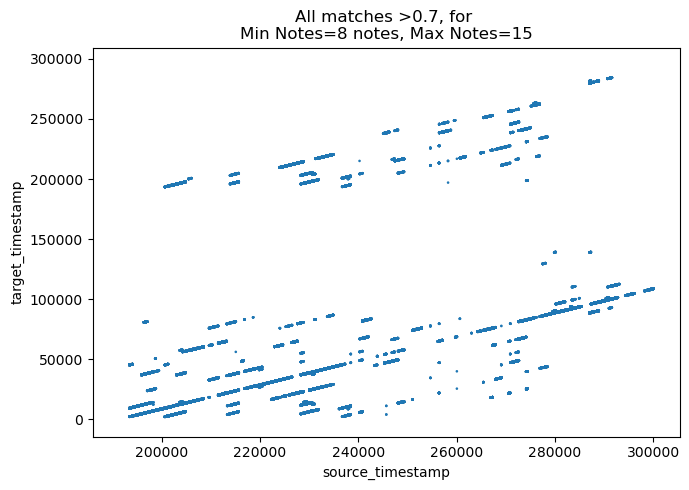

In [284]:
# plotting all mathes > threshold score

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Notes=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)


Percentage matches found: 100.0%
Percentage matches >0.7 found: 80.5%
Percentage matches within 50ms of line: 34.8%
Percentage matches >0.7 and within 50ms of the line: 33.4%
Minimum score of a "right match": 0.49


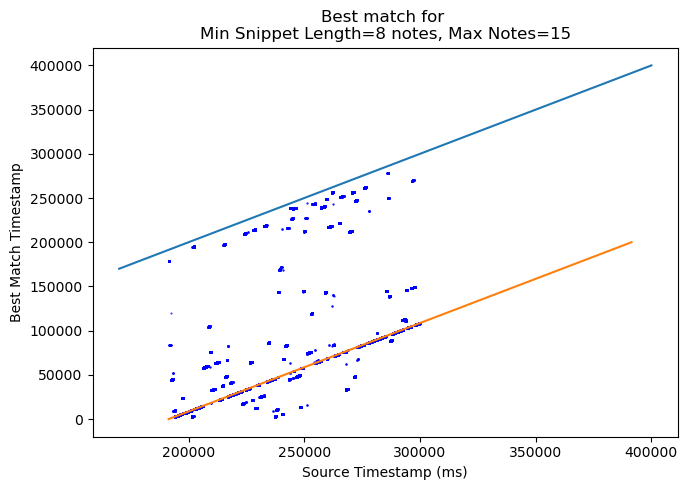

In [285]:
# Plotting best match only

percentage_matches_any = 0
percentage_matches_thresh = 0
percentage_matches_line = 0
percentage_matches_thresh_line = 0
acc = 50                            #ms accuracy for distance from line

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True
bestMatches = []

toPlot = simsDFall
# toPlot = simsDFall_old

total = 0
distribution_hist = []
distribution_all = []
close_matches = []
min_good_score = 1
for x in range(start,end,skip):
    y = toPlot.loc[toPlot['source_timestamp'] == x]['score']
    total += 1
    if y.any(): 
        y = y.idxmax()
        percentage_matches_any += 1
        if toPlot['score'].loc[y] > thresh:
            percentage_matches_thresh += 1
            if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
                percentage_matches_thresh_line += 1
        if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
            if toPlot['score'].loc[y] < min_good_score:
                min_good_score = toPlot['score'].loc[y]
            distribution_hist.append((toPlot['target_timestamp'].loc[y]-(x-191400)))
            distribution_all.append([x,(toPlot['target_timestamp'].loc[y]-(x-191400))])
            percentage_matches_line += 1
            close_matches.append(toPlot.loc[y].tolist())
    else:
        continue
#     bestMatch = [toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],toPlot['source_id_start'].loc[y],toPlot['source_id_end'].loc[y],toPlot['target_id_start'].loc[y],toPlot['target_id_end'].loc[y]]
#     bestMatches.append(bestMatch)
    plt.scatter(toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],c='blue')
# bestMatches = np.array(bestMatches)
# bestMatchesDF = pd.DataFrame(data=bestMatches, columns=["source_timestamp","target_timestamp", "score", "source_id_start", "source_id_end", "target_id_start", "target_id_end"])   

plt.plot(np.arange(170000,400000),np.arange(170000,400000))
plt.plot(np.arange(191400,391400),np.arange(200000))
percentage_matches_any /= total
percentage_matches_thresh /= total
percentage_matches_line /= total
percentage_matches_thresh_line /= total
print("Percentage matches found: {:.1f}%".format(percentage_matches_any*100))
print("Percentage matches >{:.1f} found: {:.1f}%".format(thresh,percentage_matches_thresh*100))
print("Percentage matches within {:d}ms of line: {:.1f}%".format(acc,percentage_matches_line*100))
print("Percentage matches >{:.1f} and within {:d}ms of the line: {:.1f}%".format(thresh,acc,percentage_matches_thresh_line*100))
print("Minimum score of a \"right match\": {:.2f}".format(min_good_score))

plt.title("Best match for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Timestamp")
plt.show()


In [220]:
n

3

In [212]:
data = notes[1515:1515+8][:,1]

In [213]:
h = tuple(get_hash(data, n, len(data), permutation)[0])

In [185]:
keys = list(previous_clusters.keys())
scores = [1 - cosine(cluster, h) for cluster in keys]

In [186]:
scores

[0.9978076273508656,
 0.9325352844172773,
 0.8754007185186585,
 0.9488907051639058,
 0.8665557267034658,
 0.8451718708643032,
 0.9377508559732469]

In [191]:
ind = scores.index(max(scores))
ind

0

In [201]:
snippets = list(previous_clusters[keys[ind]])

In [202]:
len(snippets)

4863

In [203]:
scores = [1 - cosine(snippet, h) for _, _, snippet in snippets] # h: hashed_source

In [204]:
list(reversed(np.argsort(scores)[-5:]))

[490, 711, 4784, 1832, 1693]

In [209]:
snippets[490][0], snippets[490][1]

(788, 9)

In [215]:
snippets[711][0], snippets[711][1]

(787, 10)

In [217]:
snippets[4784][0], snippets[4784][1]

(912, 10)

In [218]:
snippets[1832][0], snippets[1832][1]

(907, 14)

In [216]:
snippets[1693][0], snippets[1693][1]

(908, 13)

In [198]:
data

array([63, 58, 55, 58, 51, 70, 55, 58])

In [210]:
notes[788:788+9][:,1]

array([58, 58, 55, 70, 51, 58, 55, 55, 63])

In [214]:
find_from_clusters(h, 5)

[(788, 9), (787, 10), (912, 10), (907, 14), (908, 13)]

In [156]:
data

array([51, 63, 55, 58, 58, 55, 70, 51, 55, 58, 55, 63, 50, 62, 59, 55])

In [152]:
np.where(abs(notes[:,0] - 191400) < 1000)

(array([758, 759, 760, 761]),)

In [154]:
notes[755:760]

array([[171193,     55,     56],
       [172336,     60,     56],
       [172358,     72,     70],
       [191674,     51,     49],
       [191677,     63,     47]])

In [161]:
notes[1510:1518]

array([[362732,     55,     56],
       [362741,     75,     60],
       [363880,     60,     62],
       [363886,     72,     67],
       [413583,     51,     46],
       [413594,     63,     44],
       [414224,     58,     37],
       [414242,     55,     39]])

In [132]:
addToCluster(data1, 100)

In [133]:
addToCluster(data2, 101)

In [112]:
previous_clusters

{(0.5792819300549311,
  0.017784425857862687,
  0.13582186738945734,
  0.8309345058475656,
  0.3999494306967685,
  0.04850981430460316,
  0.3216284489031633,
  0.010875684477941523,
  0.016067072877949475,
  0.7059162410135207,
  0.7452482612999792,
  0.019605782081314714,
  0.5033124518679725,
  0.3923387551735851,
  0.023893955132033077,
  0.6505012091181848,
  0.3278974194187412,
  0.03573877001552488,
  0.024434642809635792,
  0.16552903522409984,
  0.06674546165381999,
  0.6071556209011668,
  0.2752643231462964,
  0.19434279046384367,
  0.4115570259848446,
  0.5675645738617374,
  0.6397360279072879,
  0.09526398146248224,
  0.30359189343579285,
  0.3988074453447379,
  0.03956717885381143,
  0.08840121370317014,
  0.530842924660195,
  0.5519799277281534,
  0.36656803943729405,
  0.5056581110283485,
  0.17155104674447424,
  0.09043982226945275,
  0.5898889115643144,
  0.018198250560159026,
  0.3151991586091907,
  0.30687659929394673,
  0.14197438633396597,
  0.48775688574660925,
  0

In [64]:
k = list(previous_clusters.keys())[0]
previous_clusters[k]

{(101, 8), 100, 8}

In [115]:
len(notes)

2992

In [125]:
data3 = notes[200:208][:,1]

In [126]:
data1, data2, data3

(array([55, 51, 67, 53, 65, 60, 56, 56]),
 array([51, 67, 53, 65, 60, 56, 56, 53]),
 array([50, 62, 55, 59, 59, 55, 50, 55]))

In [134]:
addToCluster(data3, 200)

In [135]:
len(previous_clusters.keys())

2

In [136]:
previous_clusters

{(0.5792819300549311,
  0.017784425857862687,
  0.13582186738945734,
  0.8309345058475656,
  0.3999494306967685,
  0.04850981430460316,
  0.3216284489031633,
  0.010875684477941523,
  0.016067072877949475,
  0.7059162410135207,
  0.7452482612999792,
  0.019605782081314714,
  0.5033124518679725,
  0.3923387551735851,
  0.023893955132033077,
  0.6505012091181848,
  0.3278974194187412,
  0.03573877001552488,
  0.024434642809635792,
  0.16552903522409984,
  0.06674546165381999,
  0.6071556209011668,
  0.2752643231462964,
  0.19434279046384367,
  0.4115570259848446,
  0.5675645738617374,
  0.6397360279072879,
  0.09526398146248224,
  0.30359189343579285,
  0.3988074453447379,
  0.03956717885381143,
  0.08840121370317014,
  0.530842924660195,
  0.5519799277281534,
  0.36656803943729405,
  0.5056581110283485,
  0.17155104674447424,
  0.09043982226945275,
  0.5898889115643144,
  0.018198250560159026,
  0.3151991586091907,
  0.30687659929394673,
  0.14197438633396597,
  0.48775688574660925,
  0